# CodeAlpha Task 3
## Samir Mohammed
### A/B Testing

## Introduction

- In this notebook, A/B testing will be performed on the 'Cookie Cats' mobile game dataset. The data consists of two separate categories of entries. One category has the gate level at 30, and the other at 40. In this notebook, we will analyse player retention against the two groups and see if there are any major differences.


AB Testing Process:
- Understanding business problem & data
- Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
- Look summary stats and plots
- Apply hypothesis testing and check assumptions
- Check Normality & Homogeneity
- Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
- Evaluate the results
- Make inferences
- Recommend business decision to your customer/director/ceo etc.

## Data Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("cookie_cats.csv")
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [2]:
df.info()
n_unique = df['version'].nunique()
print(f'The number of unique groups is {n_unique}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
The number of unique groups is 2


We have our two classes: gate_40 and gate_30. We can analyse their differences using statistical analyses

In [3]:
def summary(df):
    print(f'data shape: {df.shape}')  
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ

summary(df)

data shape: (90189, 5)


,data type,#missing,%missing,#unique,min,max
userid,int64,0,0.0,90189,116.0,9999861.0
version,object,0,0.0,2,NaN,NaN
sum_gamerounds,int64,0,0.0,942,0.0,49854.0
retention_1,bool,0,0.0,2,NaN,NaN
retention_7,bool,0,0.0,2,NaN,NaN


## Removing Outliers

In [4]:
# Calculate IQR 
Q1 = df.iloc[:, :-1].select_dtypes(include=['float64', 'int64']).quantile(0.25)
Q3 = df.iloc[:, :-1].select_dtypes(include=['float64', 'int64']).quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR
outliers = (
    (df.iloc[:, :-1].select_dtypes(include=['float64', 'int64']) < lower_fence) | 
    (df.iloc[:, :-1].select_dtypes(include=['float64', 'int64']) > upper_fence)
).any(axis=1)

# Remove outliers
df = df[~outliers]

# Perform Plots to Analyse Data

In [5]:
#importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

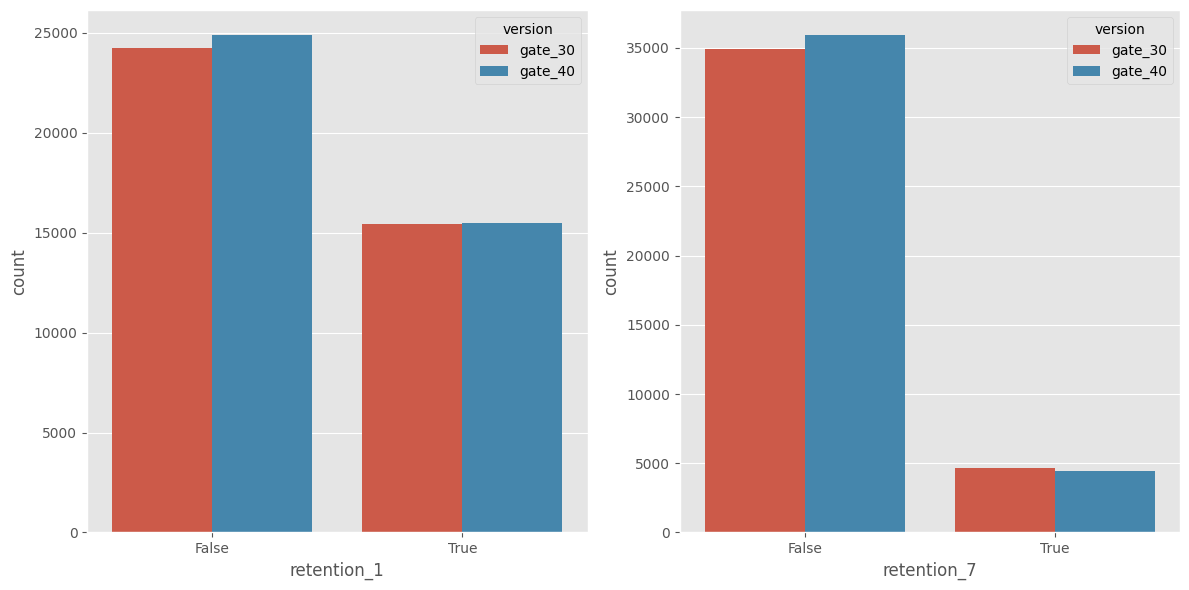

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) 
sns.countplot(data=df, x='retention_1', hue='version')
plt.subplot(1,2,2)
sns.countplot(data=df, x='retention_7', hue='version')
plt.tight_layout()


We can observe very slight differences between samples of gate 30 and gate 40. 

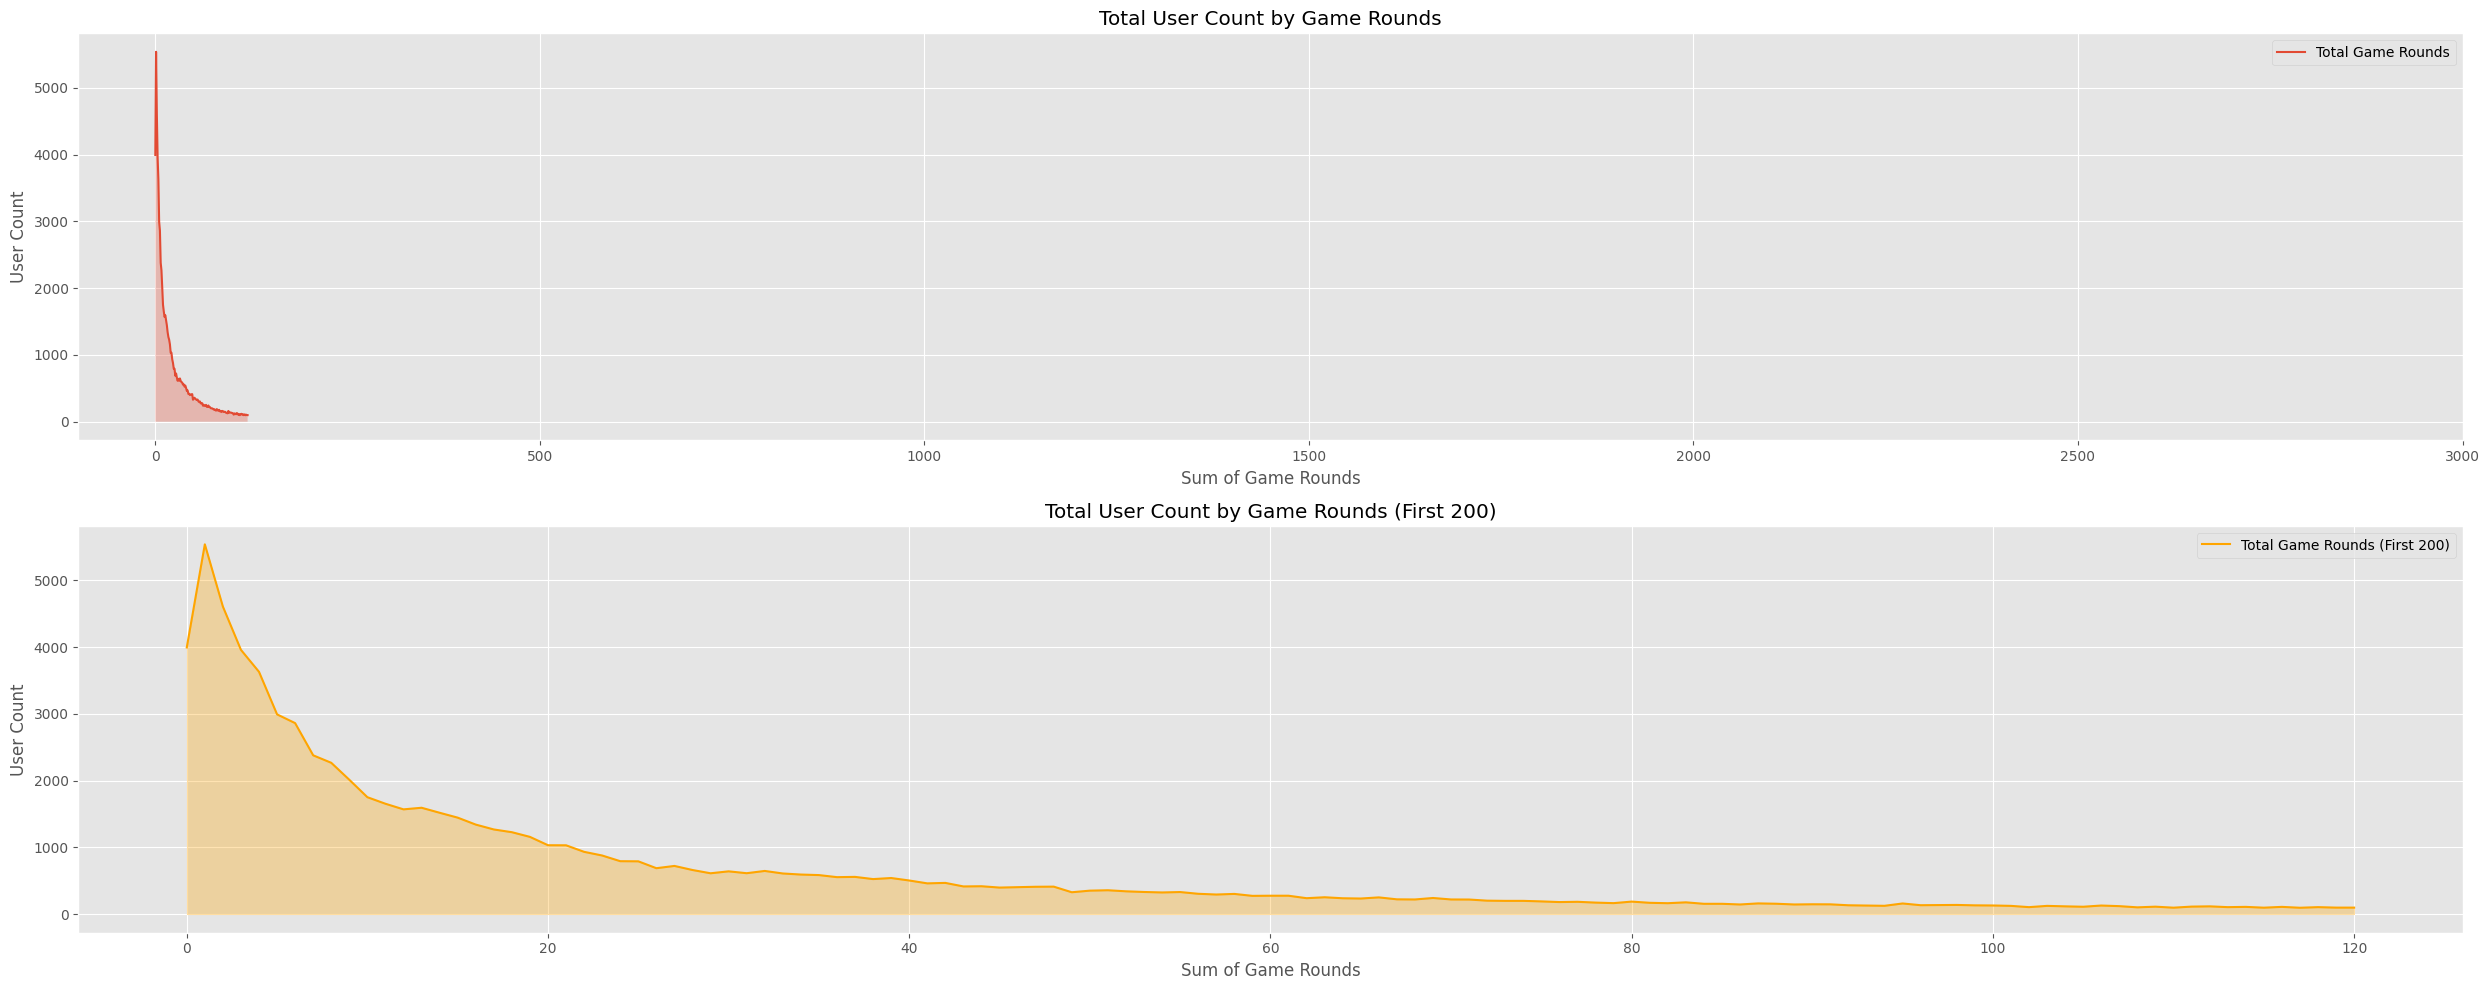

In [39]:
grouped_data = df.groupby("sum_gamerounds").userid.count()

fig, axes = plt.subplots(2, 1, figsize=(25, 10))

# First plot: all data
axes[0].plot(grouped_data.index, grouped_data.values, label='Total Game Rounds')
axes[0].fill_between(grouped_data.index, grouped_data.values, alpha=0.3)
axes[0].set_title('Total User Count by Game Rounds')
axes[0].set_xlabel('Sum of Game Rounds')
axes[0].set_ylabel('User Count')
axes[0].legend()
axes[0].set_xlim(-100,3000)

# Second plot: first 200 data points
subset_grouped_data = grouped_data[:200]
axes[1].plot(subset_grouped_data.index, subset_grouped_data.values, label='Total Game Rounds (First 200)', color='orange')
axes[1].fill_between(subset_grouped_data.index, subset_grouped_data.values, alpha=0.3, color='orange')
axes[1].set_title('Total User Count by Game Rounds (First 200)')
axes[1].set_xlabel('Sum of Game Rounds')
axes[1].set_ylabel('User Count')
axes[1].legend()

plt.tight_layout()
plt.show()

# Hypothesis Testing

We can establish some hypotheses for our test:
- H0: There are no significant differences between the two samples.
- H1: There is significant differences between the two groups. 

In [40]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

def AB_Test(dataframe, group, target):
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "gate_30"][target]
    groupB = dataframe[dataframe[group] == "gate_40"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal - False
    # H1: Distribution is not Normal - True
    
    if not ntA and not ntB:  # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity - False
        # H1: Heterogeneous - True
        
        if not leveneTest:
            # Homogeneity
            ttest = ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis": [ttest < 0.05], 
        "p-value": [ttest]
    })
    temp["Test Type"] = np.where((not ntA) and (not ntB), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if not ntA and not ntB:
        temp["Homogeneity"] = np.where(not leveneTest, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity", "AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type", "AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

# Apply A/B Testing
result = AB_Test(dataframe=df, group="version", target="sum_gamerounds")
print(result)


# A/B Testing Hypothesis
H0: A == B
H1: A != B 

        Test Type AB Hypothesis   p-value                      Comment
0  Non-Parametric     Reject H0  0.038855  A/B groups are not similar!


C:\Users\sm94c\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# Conclusion

Based on the results, gate 30 should be used as it has lower churn rates as compared to gate 40. There is significant differences between the two groups.